In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np
import os
import json
from collections import defaultdict

from regmixer.utils import config_from_path
from regmixer.eval.utils import (
    calculate_priors_with_manual,
    )

In [ ]:
# replace with your swarm config
config = "src/regmixer/config/superswarm_conditional_dclm_v2.yaml"
launch_config = config_from_path(config)


# priors[1][0] will contain a dictionary with the prior at the leaf-level.
priors = calculate_priors_with_manual(
        source_configs=launch_config.sources,
        dtype=launch_config.dtype,
        use_cache=True,
        manual_prior=launch_config.manual_prior if hasattr(launch_config, 'manual_prior') else None,
        fixed_source_weights=launch_config.fixed_source_weights if hasattr(launch_config, 'fixed_source_weights') else None,
    )

2025-06-11 15:13:01,083 - regmixer.synthesize_mixture - INFO - Source distribution cache found, using cached values at cache/priors_cache_53ba203f0375d843fa301307aba17979.json! This can be disabled by setting use_cache=False.
2025-06-11 15:13:01,084 - regmixer.eval.utils - INFO - Adjusting priors with manual prior weights: {'finemath-3plus': 0.006734006734, 'arxiv': 0.003961180432, 'pes2o': 0.0118835413, 'wikipedia': 0.001980590216, 'dclm': 0.7922360864, 's2pdf': 0.1584472173, 'stack-edu': 0.0247573777}


# Format proposed mixes

Note: this notebook currently just supports the natural distribution and mixes produced by regmixer. Doesn't support other hardcoded mixes yet (but we can easily add that - load in the mix from yaml)

In [ ]:
def get_source_mix(mix):
    # extracts source-level mix from a leaf-level mix 
    source_level = defaultdict(float)
    for source, weight in mix.items():
        if source.startswith("dclm:"):
            source_level["dclm"] += weight
        elif source.startswith("s2pdf:"):
            source_level["s2pdf"] += weight
        elif source.startswith("stack-edu:"):
            source_level["stack-edu"] += weight
        elif source.startswith("pes2o:"):
            source_level["pes2o"] += weight
        else:
            source_level[source] += weight
    return source_level

def get_topic_mix(source, mix):
    # extracts normalized topic-level mix for the source specified
    topic_weights = {k: v for k, v in mix.items() if k.startswith(source + ":")}
    total_weight = sum(topic_weights.values())
    normalized_weights = {k: v / total_weight for k, v in topic_weights.items()}

    return normalized_weights

In [ ]:
def plot_mixes(mix_dict, desc):
    # constructs a bar chart of all mixes
    # mix_dict maps from a mix name to a mix, where mix = dictionary of domains:weights 
    # desc is the title of the plot 
    mix_dict = dict(sorted(mix_dict.items()))

    # Step 2: Collect all unique keys
    all_keys = sorted(set().union(*[d.keys() for d in mix_dict.values()]))

    # Step 3: Extract values for each dict, aligning with `all_keys`
    values_matrix = [
        [d.get(k, 0) for k in all_keys]
        for d in mix_dict.values()
    ]

    # Step 4: Plot grouped bars with annotations
    n_dicts = len(mix_dict)
    x = np.arange(len(all_keys))
    bar_width = 0.8 / n_dicts

    fig, ax = plt.subplots(figsize=(20, 8))

    for i, (label, values) in enumerate(zip(mix_dict.keys(), values_matrix)):
        offset = (i - (n_dicts - 1) / 2) * bar_width
        bars = ax.bar(x + offset, values, width=bar_width, label=label)

        # Annotate each bar
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    height + 0.01,               # use this only for vertical position
                    f"{height:.3f}",             # display the correct value
                    ha='center',
                    va='bottom',
                    fontsize=10,
                    rotation=90
                )


    # Step 5: Format the plot
    ax.set_xticks(x)
    ax.set_xticklabels(all_keys, rotation=90, fontsize=16)
    ax.set_ylabel("Value")
    ax.set_title(desc, fontsize=20)
    ax.legend(title="Source", fontsize=16)
    plt.tight_layout()
    plt.show()


Load in data from rmc-eval output

In [12]:
path = "output/84313ca4/fixed_basic_proposed_mix/a171c3de56b7f486/olmo3_offline_tasks_log_linear_reg_1_samples_optimal.json"
with open(path, "r") as f:
    unconstrained_mix = json.load(f)

unconstrained_mix = {m['domain']: m['weight'] for m in unconstrained_mix}

In [ ]:
# this folder contains all the proposed mixes where we set --repetition-factor
folder = "output/84313ca4/fixed_sweep_repetition_factor"
runs = os.listdir(folder)

sweep_repetition_factor = {}
for run in runs:
    config_path = os.path.join(folder, run, "config.json")
    mix_path = os.path.join(folder, run, "olmo3_offline_tasks_log_linear_reg_1_samples_optimal.json")

    with open(config_path, "r") as f:   
        config = json.load(f)

    if 'repetition_factor' in config:
        repetition_factor = config['repetition_factor']
    else:
        repetition_factor = 1

    print(mix_path, repetition_factor)

    with open(mix_path, "r") as f:
        mix = json.load(f)

    sweep_repetition_factor[str(repetition_factor)] = {m['domain']: m['weight'] for m in mix}


output/84313ca4/fixed_sweep_repetition_factor/6a378e3367e9bb04/olmo3_offline_tasks_log_linear_reg_1_samples_optimal.json 5.0
output/84313ca4/fixed_sweep_repetition_factor/dc1748f348b99a5b/olmo3_offline_tasks_log_linear_reg_1_samples_optimal.json 3.0
output/84313ca4/fixed_sweep_repetition_factor/3a28bff99c94fed7/olmo3_offline_tasks_log_linear_reg_1_samples_optimal.json 4.0


In [ ]:
all_source_mixes = {}
for rep, mix in sweep_repetition_factor.items():
    source_mix = get_source_mix(mix)
    all_source_mixes[f"v2 {rep}"] = source_mix

all_source_mixes['unconstrained'] = get_source_mix(unconstrained_mix)
all_source_mixes['manual prior'] = get_source_mix(priors[1][0])

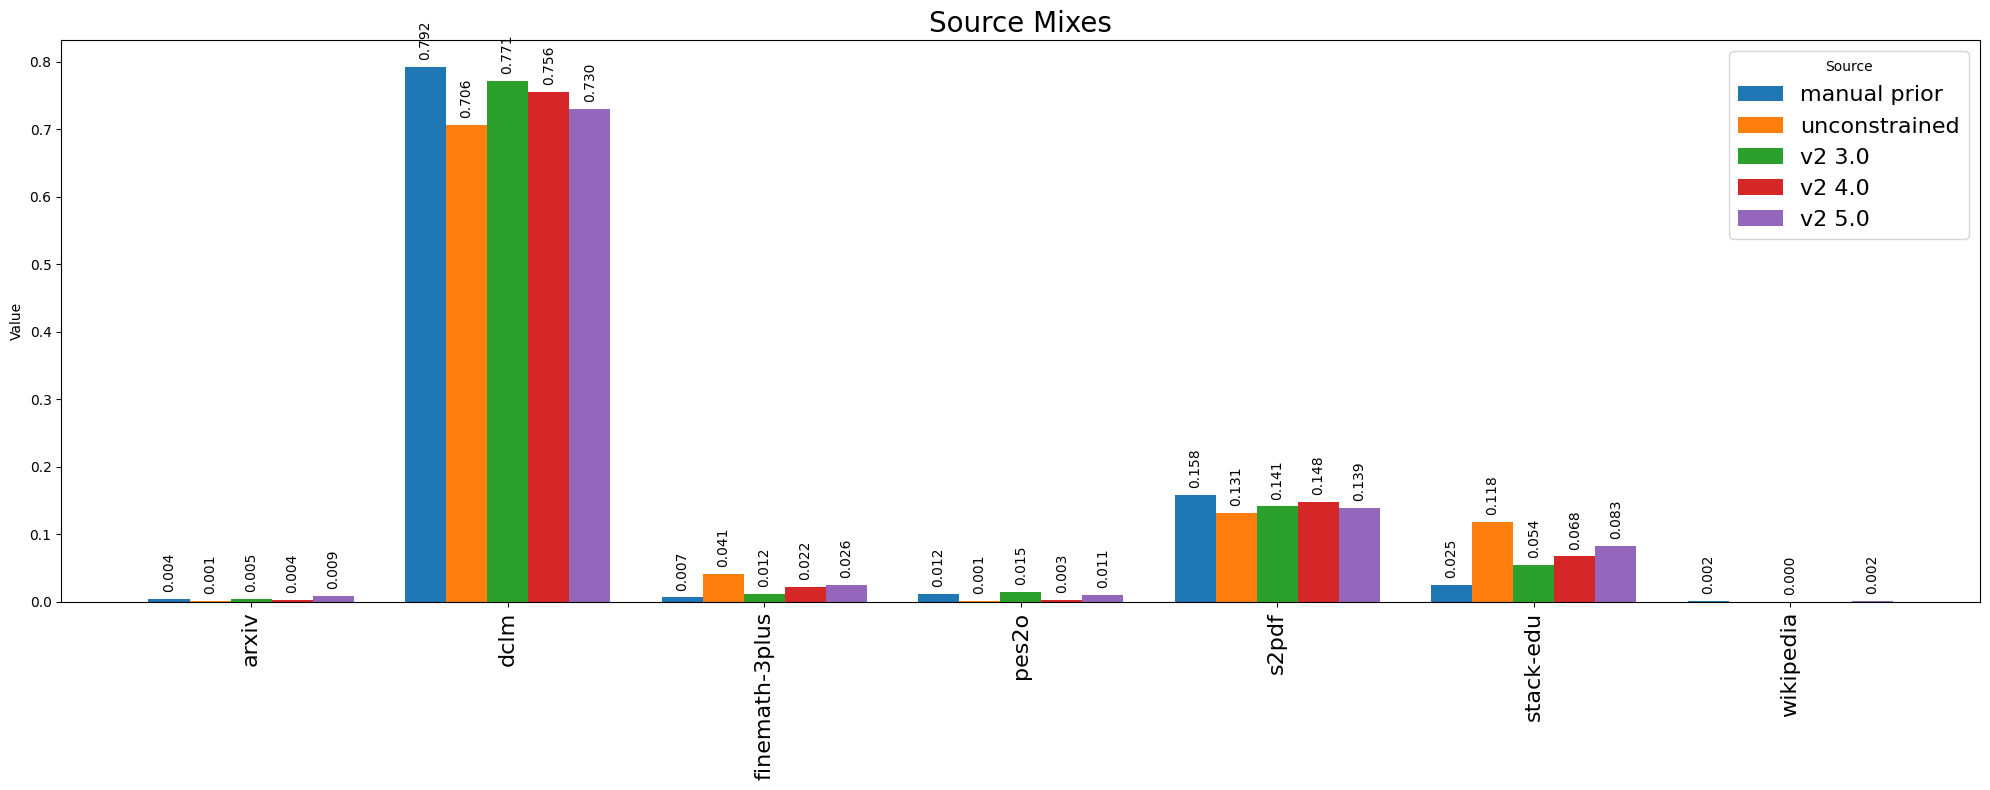

In [34]:
plot_mixes(all_source_mixes, "Source Mixes")

DCLM mixes - note that these should all look the same if we are conditioning on DCLM p*, so this isn't really needed

In [40]:
all_dclm_mixes = {}
for rep, mix in sweep_repetition_factor.items():
    dclm_mix = get_topic_mix("dclm", mix)
    all_dclm_mixes[rep] = dclm_mix


all_dclm_mixes['unconstrained'] = get_topic_mix("dclm", unconstrained_mix)

all_dclm_mixes['manual prior'] = get_topic_mix("dclm", priors[1][0])

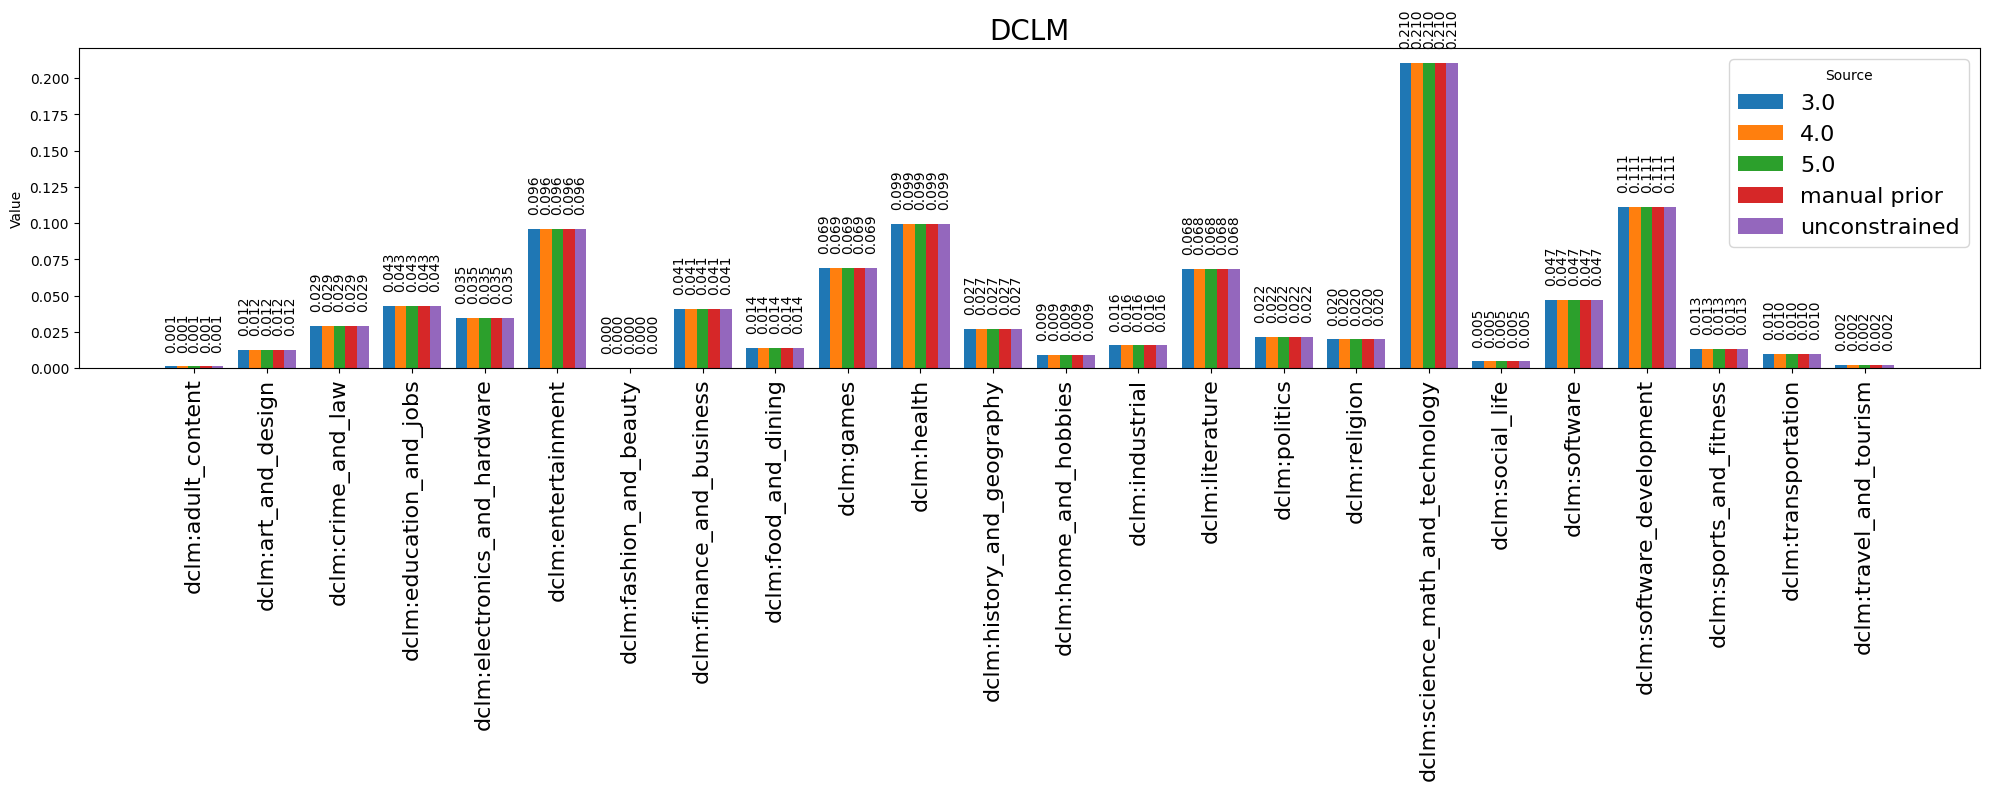

In [41]:
plot_mixes(all_dclm_mixes, "DCLM")

s2pdf mixes

In [ ]:
all_s2pdf_mixes = {}
for rep, mix in sweep_repetition_factor.items():
    dclm_mix = get_topic_mix("s2pdf", mix)
    all_s2pdf_mixes[rep] = dclm_mix

all_s2pdf_mixes['unconstrained'] = get_topic_mix("s2pdf", unconstrained_mix)
all_s2pdf_mixes['manual prior'] = get_topic_mix("s2pdf", priors[1][0])

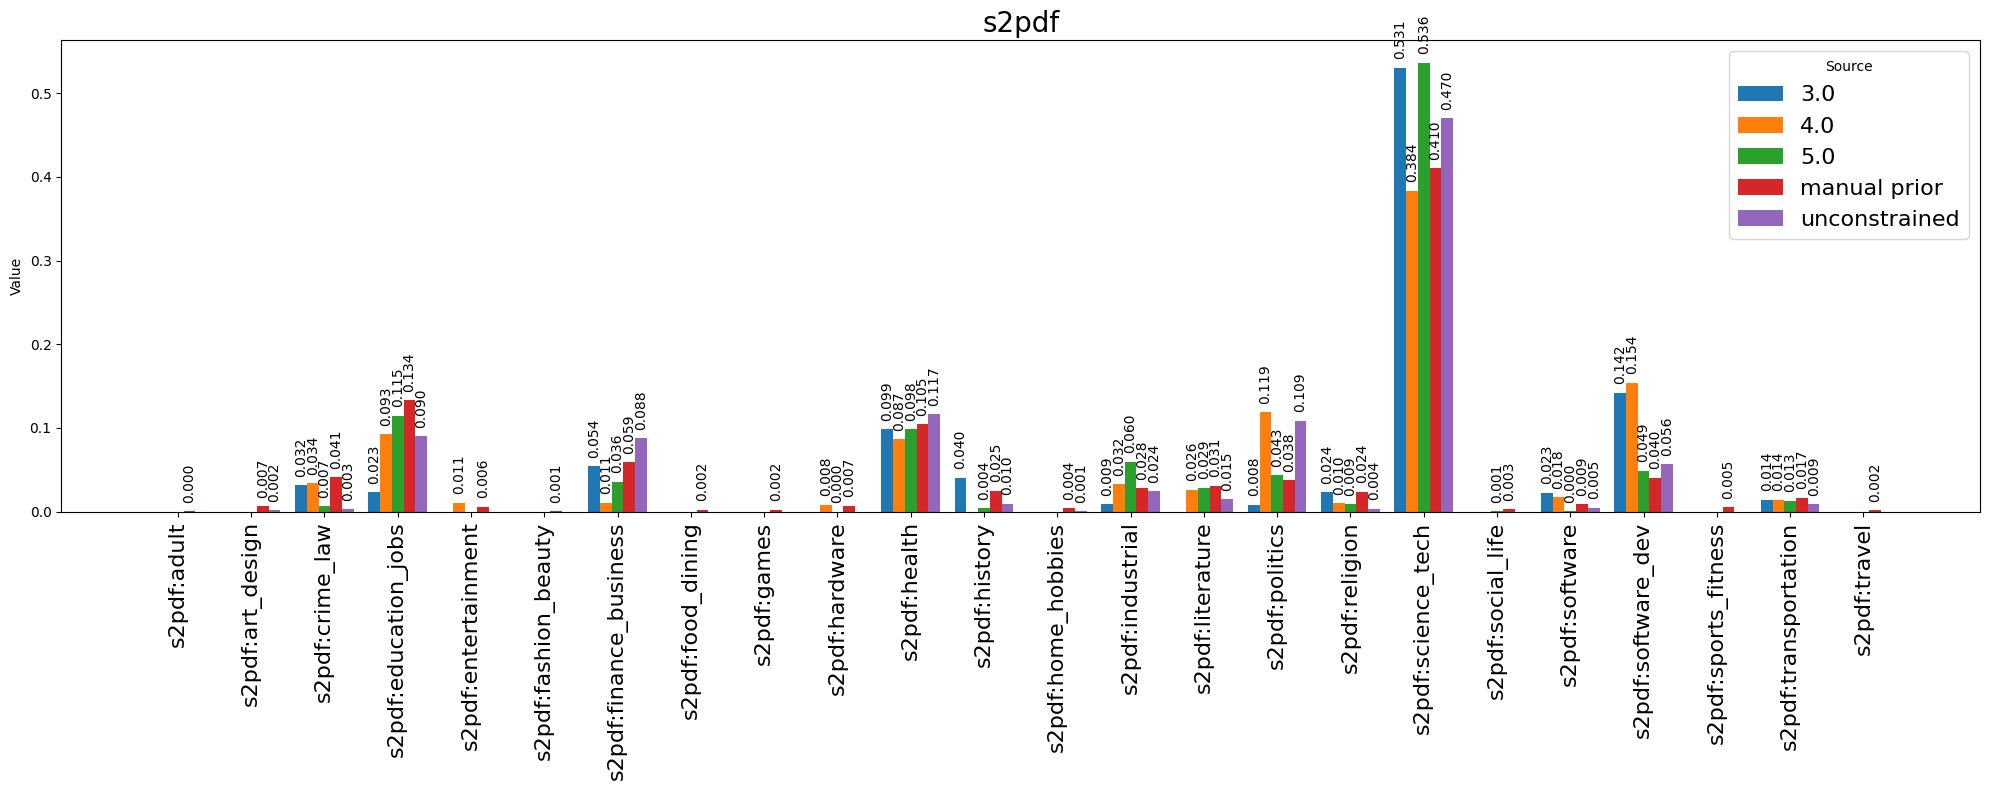

In [35]:
plot_mixes(all_s2pdf_mixes, "s2pdf")

And so on for other sources. For latest superswarm we mainly just need to look at s2pdf and pes2o mixes? 